In [196]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import seaborn as sns
from collections import defaultdict

sns.set_theme(style="whitegrid", context="paper")
sns.set_palette("coolwarm")
rs = check_random_state(42)

In [197]:
data_fama_french = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3)
data_fama_french_daily = pd.read_csv("data/F-F_Research_Data_5_Factors_2x3_daily.CSV", skiprows=3)
# data_stocks = pd.read_csv("data/characteristics_data_feb2017.csv")

In [198]:
data_fama_french["Date"] = pd.to_datetime(data_fama_french["Date"], format="%Y%m")
data_fama_french = data_fama_french.set_index("Date")

data_fama_french_daily["Date"] = pd.to_datetime(data_fama_french_daily["Date"], format="%Y%m%d")
data_fama_french_daily = data_fama_french_daily.set_index("Date")

# data_fama_french[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] /= 100
# leaving the data in percentage format to reduce float precision errors

data_fama_french

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2024-08-01,1.61,-3.65,-1.13,0.85,0.86,0.48
2024-09-01,1.74,-1.02,-2.59,0.04,-0.26,0.40
2024-10-01,-0.97,-0.88,0.89,-1.38,1.03,0.39


In [199]:
# data_stocks.drop(
#     columns=[
#         "idx",
#         "q10",
#         "q20",
#         "q50",
#         "prc",
#         "a2me",
#         "ato",
#         "beme",
#         "c",
#         "cto",
#         "d2a",
#         "dpi2a",
#         "e2p",
#         "fc2y",
#         "free_cf",
#         "investment",
#         "lturnover",
#         "noa",
#         "oa",
#         "ol",
#         "pcm",
#         "pm",
#         "prof",
#         "q",
#         "rna",
#         "roa",
#         "roe",
#         "s2p",
#         "sga2m",
#         "at",
#         "cum_return_12_2",
#         "cum_return_12_7",
#         "cum_return_1_0",
#         "cum_return_36_13",
#         "idio_vol",
#         "spread_mean",
#         "suv",
#         "rel_to_high_price",
#         "lev",
#     ],
#     inplace=True,
# )

# data_stocks.sort_values(by=["date"], ascending=[True], inplace=True)
# data_stocks["date"] = pd.to_datetime(data_stocks["date"])
# data_stocks.head()

Nauči model na svih 6 parametara iz Fama-French podataka po cijeloj povijesti.
Vidi jesu li bolja 2, 3 ili 4 stanja
Full covar
GaussianHMM

In [232]:
# X = data_fama_french.values.reshape(-1, 1)
# lengths = [len(data_fama_french)] * 6

X = data_fama_french.values
lengths = [len(data_fama_french)]

X_daily = data_fama_french_daily.values
lengths_daily = [len(data_fama_french_daily)]

In [233]:
# TODO add K-means initialization
# TODO return the best model, the standard deviation of the parameters, and the number of iterations
# TODO histogram of log likelihoods

def evaluate_hmm(X, lengths, rs):
    aic = []
    bic = []
    lls = []
    convergence_status = []
    iterations = []
    ns = [2, 3, 4, 5]
    models = defaultdict(list)
    # save in this format: {number_of_states: [(model, LL), ...]}
    best_models = defaultdict()

    for n in ns:
        best_ll = None
        best_model = None
        for _ in range(200):
            h = GaussianHMM(
                n,
                n_iter=2000,
                tol=1e-6,
                random_state=rs,
                covariance_type="full",
                verbose=False,
            )
            h.fit(X, lengths)
            score = h.score(X, lengths)
            models[n].append((h, score))
            if not best_ll or best_ll < score:
                best_ll = score
                best_model = h

        best_models[n] = best_model
        aic.append(best_model.aic(X))
        bic.append(best_model.bic(X))
        lls.append(best_model.score(X))
        convergence_status.append(best_model.monitor_.converged)
        iterations.append(best_model.monitor_.iter)

    print("Convergence Status: ", convergence_status)
    print("Iterations: ", iterations)
    return aic, bic, lls, convergence_status, iterations, best_models, models


In [234]:
def plot_selection(ns, aic, bic, lls):
    fig, ax = plt.subplots()
    ax.plot(ns, aic, label="AIC", color="blue", marker="o")
    ax.plot(ns, bic, label="BIC", color="green", marker="o")
    ax2 = ax.twinx()
    ax2.plot(ns, lls, label="LL", color="orange", marker="o")
    ax.legend(handles=ax.lines + ax2.lines)
    ax.set_title("Using AIC/BIC for Model Selection")
    ax.set_ylabel("Criterion Value (lower is better)")
    ax2.set_ylabel("LL (higher is better)")
    ax.set_xlabel("Number of HMM Components")
    fig.tight_layout()
    plt.show()


# TODO add heuristic to choose optimal number of components, currently visually finding the elbow

In [235]:
def plot_ll_histograms(models):
    ns = sorted(models.keys())
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for idx, n_components in enumerate(ns):
        component_scores = [score for (_, score) in models[n_components]]
        
        axes[idx].hist(component_scores, 
                      bins=25, 
                      edgecolor='k', 
                      alpha=0.65,
                      density=True)
        
        axes[idx].set_title(f'{n_components}-State HMM\n(n={len(component_scores)})', pad=12)
        axes[idx].set_xlabel('Log-Likelihood', labelpad=8)
        axes[idx].set_ylabel('Density', labelpad=8)
        axes[idx].grid(True, linestyle='--', alpha=0.6)
        
        mean_ll = np.mean(component_scores)
        axes[idx].axvline(mean_ll, color='r', linestyle='--', 
                         linewidth=1.5, label=f'Mean: {mean_ll:.1f}')
        axes[idx].legend()
    
    plt.tight_layout(pad=2.0)
    plt.show()


Model is not converging.  Current: -8347.475415212639 is not greater than -8347.475404369192. Delta is -1.084344694390893e-05
Model is not converging.  Current: -8347.475469167473 is not greater than -8347.47541505725. Delta is -5.4110223572934046e-05
Model is not converging.  Current: -8233.151182028245 is not greater than -8233.151172282485. Delta is -9.745759598445147e-06
Model is not converging.  Current: -8233.151182160482 is not greater than -8233.15117235874. Delta is -9.801742635318078e-06
Model is not converging.  Current: -8233.15117927016 is not greater than -8233.151171085585. Delta is -8.184575563063845e-06
Model is not converging.  Current: -8233.151174468963 is not greater than -8233.1511719266. Delta is -2.542363290558569e-06
Model is not converging.  Current: -7887.634003740608 is not greater than -7887.63398902591. Delta is -1.4714698409079574e-05
Model is not converging.  Current: -7857.762943394057 is not greater than -7857.762943311864. Delta is -8.219376468332484e

Convergence Status:  [True, True, True, True]
Iterations:  [38, 120, 56, 56]


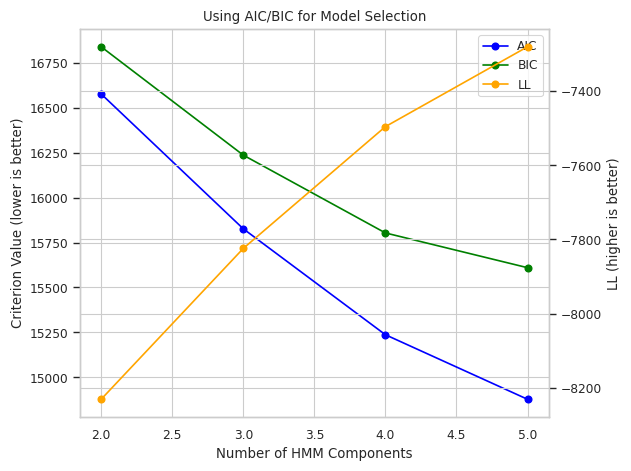

In [236]:
aic, bic, lls, convergence_status, iterations, best_models, models = evaluate_hmm(X, lengths, rs)
plot_selection([2, 3, 4, 5], aic, bic, lls)

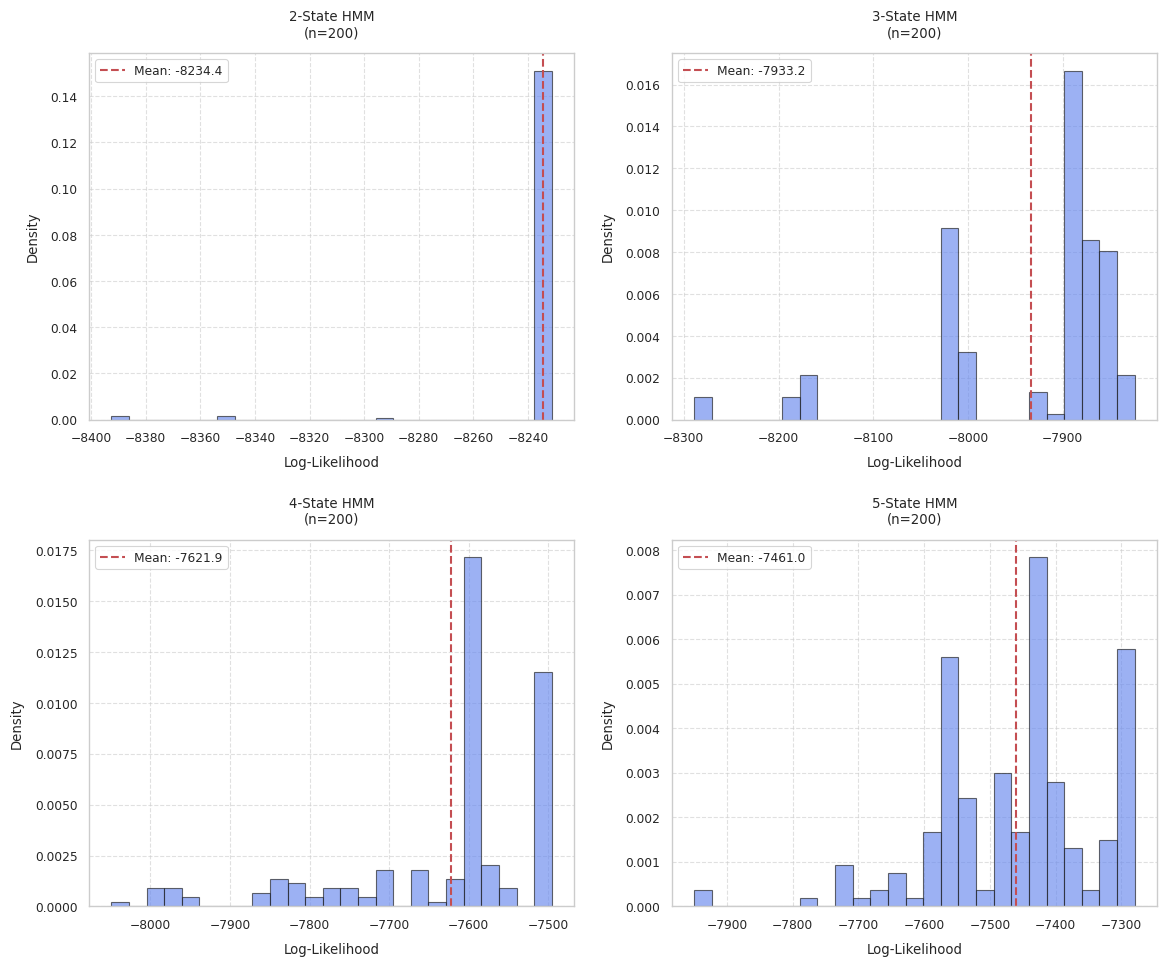

In [237]:
plot_ll_histograms(models)

Zaključujemo da je 4 optimalan broj stanja

In [238]:
h = best_models[4]

print(h.score(X, lengths))

hidden_states = h.predict(X, lengths=len(X))

-7495.500874506202


In [239]:
def remap_hidden_states_by_covariance(h, hidden_states):
    cov_traces = [np.trace(c) for c in h.covars_]
    
    sorted_indices = np.argsort(cov_traces)
    
    h.means_ = h.means_[sorted_indices]
    h.covars_ = h.covars_[sorted_indices]
    h.transmat_ = h.transmat_[sorted_indices, :][:, sorted_indices]
    h.startprob_ = h.startprob_[sorted_indices]
    
    state_mapping = {old: new for new, old in enumerate(sorted_indices)}
    
    hidden_states = np.vectorize(state_mapping.get)(hidden_states)
    
    return hidden_states

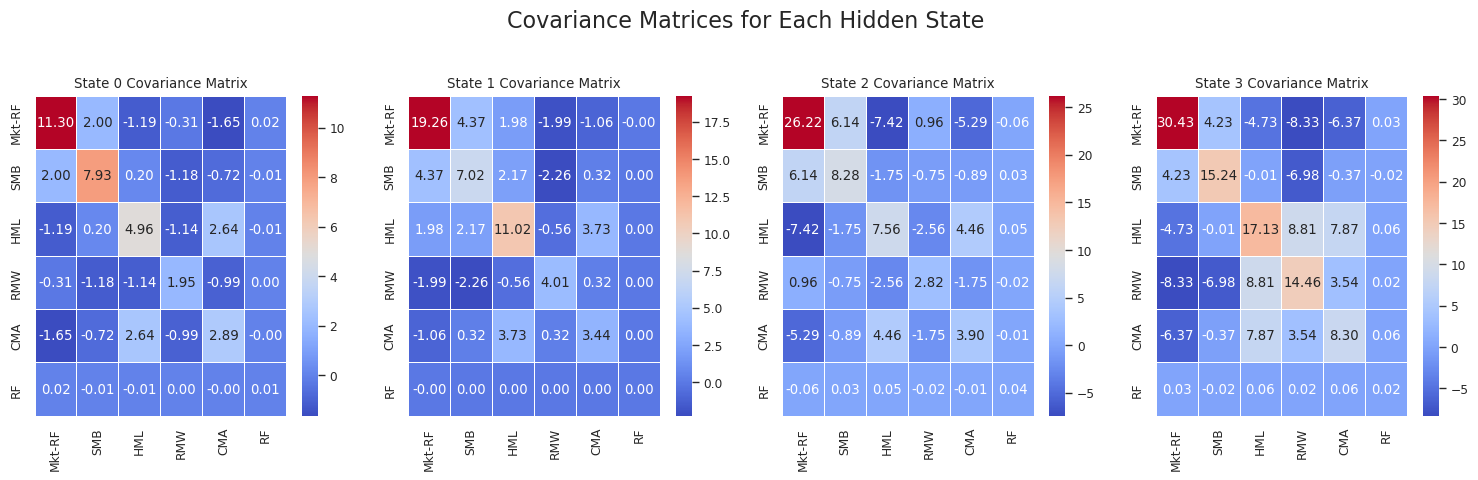

In [240]:
# use previous function to remap the hidden states
hidden_states = remap_hidden_states_by_covariance(h, hidden_states)

covariance_matrices = h.covars_

factor_names = data_fama_french.columns.tolist()

num_states = len(covariance_matrices)
fig, axes = plt.subplots(1, num_states, figsize=(15, 5))

for i in range(num_states):
    cov_matrix = covariance_matrices[i]

    sns.heatmap(
        cov_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        ax=axes[i],
        xticklabels=factor_names,
        yticklabels=factor_names,
    )
    axes[i].set_title(f"State {i} Covariance Matrix")

plt.suptitle("Covariance Matrices for Each Hidden State", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

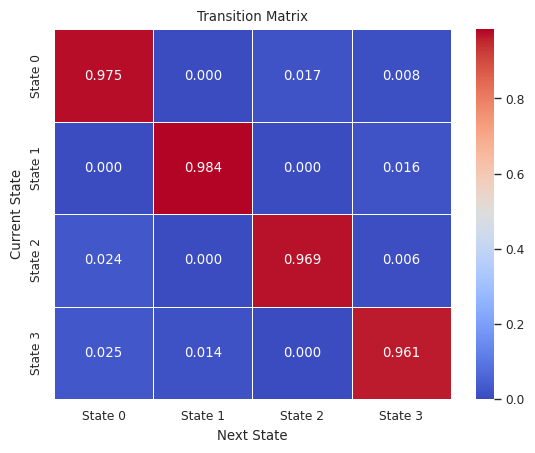

In [241]:
# plot transition matrix
fig, ax = plt.subplots()
sns.heatmap(
    h.transmat_,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    ax=ax,
    xticklabels=[f"State {i}" for i in range(num_states)],
    yticklabels=[f"State {i}" for i in range(num_states)],
)
ax.set_title("Transition Matrix")
plt.xlabel("Next State")
plt.ylabel("Current State")
plt.show()

In [242]:
# calculate the average length of each state
state_lengths = defaultdict(list)

current_state = hidden_states[0]
counter = 1
for state in hidden_states[1:]:
    if state == current_state:
        counter += 1
    else:
        state_lengths[current_state].append(counter)
        counter = 1
        current_state = state

# sorted keys
sorted_keys = sorted(state_lengths.keys())
state_lengths = {key: state_lengths[key] for key in sorted_keys}
average_lengths = {state: np.mean(lengths) for state, lengths in state_lengths.items()}

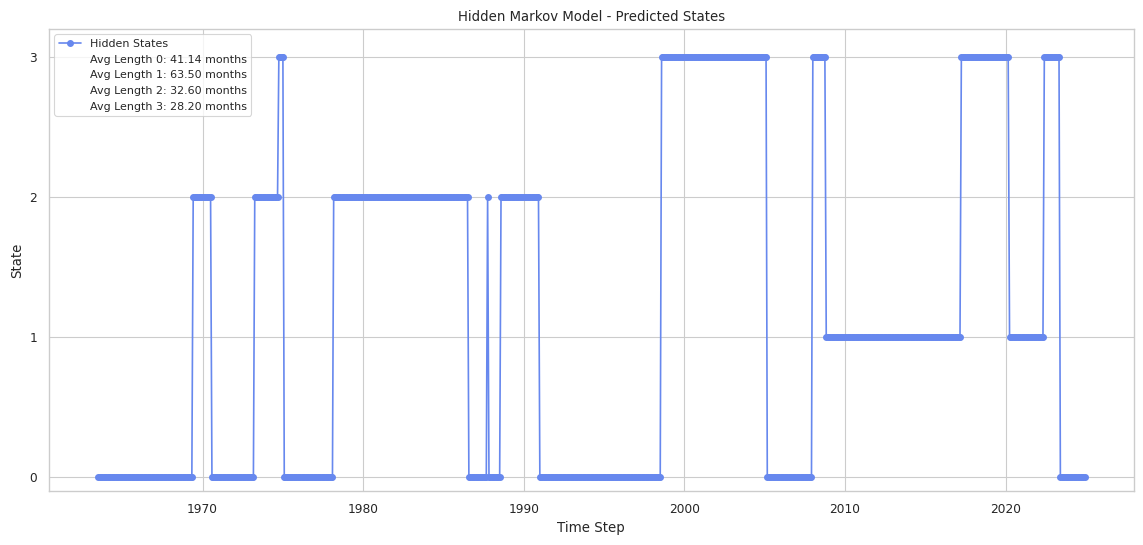

In [243]:
plt.figure(figsize=(14, 6))
plt.plot(
    data_fama_french.index,
    hidden_states,
    label="Hidden States",
    marker="o",
    linestyle="-",
    markersize=4,
)
plt.title("Hidden Markov Model - Predicted States")
plt.xlabel("Time Step")
plt.ylim(-0.1, h.n_components - 0.8)
plt.ylabel("State")
plt.yticks(np.arange(h.n_components))

for state, lengths in average_lengths.items():
    plt.plot([], [], " ", label=f"Avg Length {state}: {lengths:.2f} months")
plt.legend(loc="upper left", fontsize="small")
plt.grid(True)

plt.show()

In [244]:
model_2_states = best_models[2]

model_3_states = best_models[3]

In [245]:
state_probs_2 = model_2_states.predict_proba(X, lengths=len(X))
state_probs_3 = model_3_states.predict_proba(X, lengths=len(X))
state_probs_4 = h.predict_proba(X, lengths=len(X))

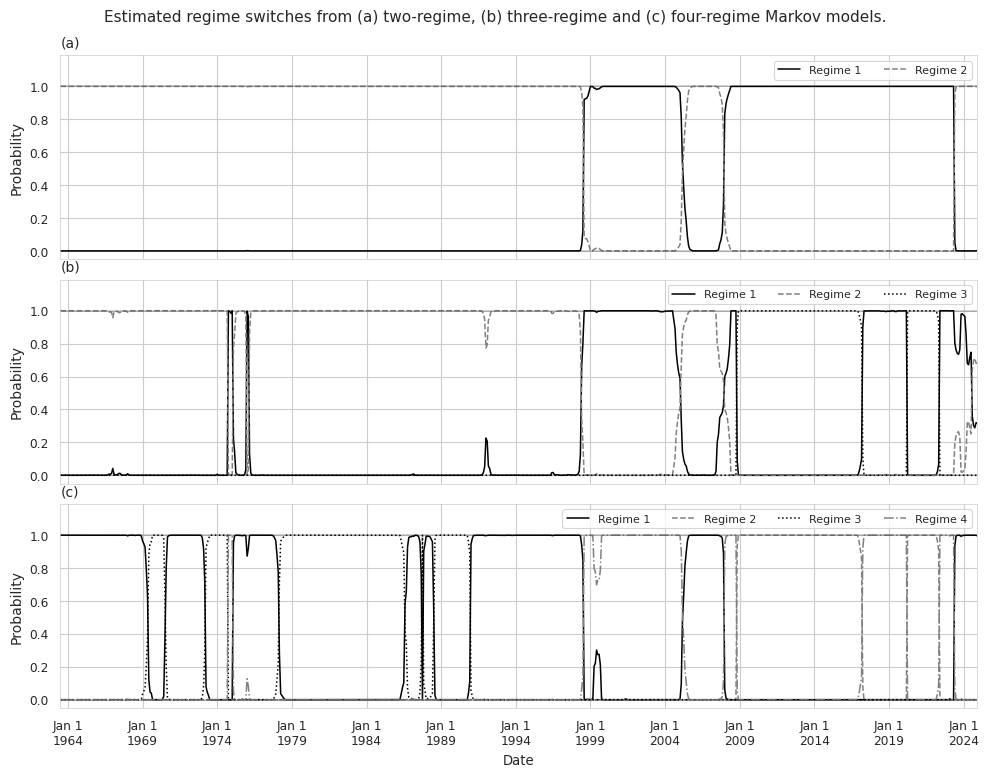

In [246]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
fig.text(0.5, 0.95, 'Estimated regime switches from (a) two-regime, (b) three-regime and (c) four-regime Markov models.', 
         ha='center', fontsize=11)

line_styles = ['-', '--', ':', '-.']
colors = ['black', 'gray', 'black', 'gray']

titles = ['(a)', '(b)', '(c)']
probs = [state_probs_2, state_probs_3, state_probs_4]
n_regimes = [2, 3, 4]

for i, (ax, prob, n_regime) in enumerate(zip(axes, probs, n_regimes)):
    ax.set_title(titles[i], loc='left', fontsize=10)
    
    for j in range(n_regime):
        sns.lineplot(
            x=data_fama_french.index, 
            y=prob[:, j],
            ax=ax,
            linestyle=line_styles[j % len(line_styles)],
            color=colors[j % len(colors)],
            linewidth=1.1,
            label=f'Regime {j+1}'
        )
    
    ax.legend(loc='upper right', ncol=n_regime, frameon=True, fontsize="small")
    
    ax.set_ylim(-0.05, 1.19)
    ax.set_ylabel('Probability', fontsize=10)

    ax.set_xlim(data_fama_french.index[0], data_fama_french.index[-1])
    
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2)
    ax.axhline(y=1, color='black', linestyle='-', alpha=0.2)

year_ticks = pd.date_range(start=data_fama_french.index[0], end=data_fama_french.index[-1], freq='5YS')
axes[2].set_xticks(year_ticks)
axes[2].set_xticklabels([f'Jan 1\n{date.year}' for date in year_ticks])

sns.despine()

for ax in axes:
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_linewidth(0.5)
    ax.spines['right'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.1)
plt.show()


In [247]:
# TODO spremiti model s najboljim LL i vidjeti jesu li uvijek slična stanja
# TODO provjeriti koliko se LL razlikuje između modela
